In [167]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

In [ ]:
bens_cand = pd.read_csv('bem_candidato_2018_BRASIL.csv')
consulta_cand = pd.read_csv('consulta_cand_2018_BRASIL.csv')

In [106]:
# Fundindo os dataframes
bens_consulta = pd.merge(consulta_cand, bens_cand, "inner", "SQ_CANDIDATO")

In [108]:
# Limitando escopo para primeiro turno, para candidaturas deferidas, para eleições estaduais no Estado
# de São Paulo e para o cargo de deputado estadual
bens_consulta = bens_consulta[
    (bens_consulta['DS_DETALHE_SITUACAO_CAND'].isin(['DEFERIDO', 'DEFERIDO COM RECURSO'])) & 
    (bens_consulta['NR_TURNO'] == 1) &
    (bens_consulta['SG_UF_x'] == 'SP') &
    (bens_consulta['DS_CARGO'] == 'DEPUTADO ESTADUAL')
]

# Dropando colunas desnecessárias
bens_consulta = bens_consulta.drop(columns=[
    "CD_ELEICAO_x",
    "CD_ELEICAO_y",
    "TP_ABRANGENCIA",
    "CD_TIPO_ELEICAO_x",
    "CD_TIPO_ELEICAO_y",
    "NM_TIPO_ELEICAO_x",
    "NM_TIPO_ELEICAO_y",
    "DT_ELEICAO_x",
    "DT_ELEICAO_y",
    "DS_ELEICAO_x",
    "DS_ELEICAO_y",
    "SG_UF_x",
    "SG_UF_y",
    "SG_UE_x",
    "SG_UE_y",
    "NM_UE_x",
    "NM_UE_y",
    "CD_CARGO",
    "DS_CARGO",
    "NR_PARTIDO",
    "SG_PARTIDO",
    "SQ_COLIGACAO",
    "DS_COMPOSICAO_COLIGACAO",
    "TP_AGREMIACAO",
    "SQ_CANDIDATO",
    "NR_CANDIDATO",
    "NM_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NM_SOCIAL_CANDIDATO",
    "NR_CPF_CANDIDATO",
    "NM_EMAIL",
    "NR_TITULO_ELEITORAL_CANDIDATO",
    "CD_NACIONALIDADE",
    "CD_MUNICIPIO_NASCIMENTO",
    "NM_MUNICIPIO_NASCIMENTO",
    "DT_NASCIMENTO",
    "CD_GENERO",
    "CD_GRAU_INSTRUCAO",
    "CD_ESTADO_CIVIL",
    "CD_COR_RACA",
    "CD_OCUPACAO",
    "CD_TIPO_BEM_CANDIDATO",
    "DS_TIPO_BEM_CANDIDATO",
    "DS_BEM_CANDIDATO",
    "CD_SITUACAO_CANDIDATURA",
    "DS_SITUACAO_CANDIDATURA",
    "CD_DETALHE_SITUACAO_CAND",
    "DS_DETALHE_SITUACAO_CAND",
    "NR_DESPESA_MAX_CAMPANHA",
    "DT_GERACAO_x",
    "DT_GERACAO_y",
    "HH_GERACAO_x",
    "HH_GERACAO_y",
    "ANO_ELEICAO_x",
    "ANO_ELEICAO_y",
    "NR_TURNO",
    "CD_SIT_TOT_TURNO",
    "ST_DECLARAR_BENS",
    "NR_PROTOCOLO_CANDIDATURA",
    "NR_ORDEM_CANDIDATO",
    "NR_PROCESSO",
    "DT_ULTIMA_ATUALIZACAO",
    "HH_ULTIMA_ATUALIZACAO"
])

In [110]:
# Convertendo valor de declaração para numérico
bens_consulta['VR_BEM_CANDIDATO'] = bens_consulta['VR_BEM_CANDIDATO'].str.replace(',', '.')
bens_consulta['VR_BEM_CANDIDATO'] = bens_consulta['VR_BEM_CANDIDATO'].astype(float)

In [111]:
# Transformando coluna idade em categórica
idade = pd.cut(
    bens_consulta['NR_IDADE_DATA_POSSE'],
    bins=[0, 29, 59, 99],
    labels=['JOVEM', 'ADULTO', 'IDOSO']
)
bens_consulta.insert(4, 'CLASSIFICACAO_ETARIA', idade)
bens_consulta = bens_consulta.drop(columns=['NR_IDADE_DATA_POSSE'])

# Convertendo coluna de categoria para string
bens_consulta['CLASSIFICACAO_ETARIA'] = bens_consulta['CLASSIFICACAO_ETARIA'].astype('object')

In [113]:
# Diminuindo o número de profissões
ocupacao = bens_consulta['DS_OCUPACAO'].value_counts().rename_axis('DS_OCUPACAO').reset_index(name='counts')
profissoes_com_menos_de_10_ocorrencias = ocupacao[ocupacao['counts'] < 10]
profissoes_com_menos_de_10_ocorrencias = profissoes_com_menos_de_10_ocorrencias.iloc[:, 0]

bens_consulta['DS_OCUPACAO'] = np.where(
    bens_consulta['DS_OCUPACAO'].isin(profissoes_com_menos_de_10_ocorrencias),
    'OUTROS',
    bens_consulta['DS_OCUPACAO']
)

In [114]:
# Diminuindo o número de Estados
regioes = {
    'SUL': ['SC', 'PR', 'RS'],
    'NORTE': ['AM', 'AP', 'AC', 'PA', 'RO', 'RR', 'TO'],
    'NORDESTE': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'CENTRO_OESTE': ['GO', 'MT', 'MS'],
    'SUDESTE': ['ES', 'MG', 'RJ', 'SP']
}

for regiao in regioes.keys():
    bens_consulta['SG_UF_NASCIMENTO'] = np.where(
        bens_consulta['SG_UF_NASCIMENTO'].isin(regioes[regiao]),
        regiao,
        bens_consulta['SG_UF_NASCIMENTO']
    )

In [143]:
# Removendo valor estranho de Estado de nascimento
bens_consulta = bens_consulta[bens_consulta['SG_UF_NASCIMENTO'] != 'ZZ']

In [136]:
# Transformando target
import numpy as np

bens_consulta['DS_SIT_TOT_TURNO'] = np.where(
    bens_consulta['DS_SIT_TOT_TURNO'].isin(['SUPLENTE', 'NÃO ELEITO']),
    0,
    bens_consulta['DS_SIT_TOT_TURNO']
)
bens_consulta['DS_SIT_TOT_TURNO'] = np.where(
    bens_consulta['DS_SIT_TOT_TURNO'].isin(['ELEITO POR QP','ELEITO POR MÉDIA','ELEITO']),
    1,
    bens_consulta['DS_SIT_TOT_TURNO']
)


In [137]:
bens_consulta['DS_SIT_TOT_TURNO'].value_counts()

0    5681
1     891
Name: DS_SIT_TOT_TURNO, dtype: int64

In [138]:
bens_consulta.head()

,NM_PARTIDO,NM_COLIGACAO,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CLASSIFICACAO_ETARIA,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,DS_SIT_TOT_TURNO,ST_REELEICAO,VR_BEM_CANDIDATO
18,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,45000.00
19,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,151419.14
20,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,474.28
21,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,362086.34
22,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,PSDB-PSD-DEM-PP-PRB,BRASILEIRA NATA,SUDESTE,IDOSO,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,DEPUTADO,1,S,30000.00


In [145]:
# Removendo valores nulos
bens_consulta_enc = bens_consulta.dropna()

for column in bens_consulta_enc.columns:
    if 'nan' in column:
        bens_consulta_enc = bens_consulta_enc.drop(columns=column)

In [126]:
seed=42
scoring = 'f1'

X = bens_consulta_enc.drop(columns=['DS_SIT_TOT_TURNO'])
y = bens_consulta_enc['DS_SIT_TOT_TURNO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [165]:
# Otimizando hiperparâmetros para Decision Tree
lista_etapas = [("dt", DecisionTreeClassifier())]

pipe = Pipeline(lista_etapas)

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrica = make_scorer(f1_score)

params_grid_dt = {"dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 5)} 

grid_dt = GridSearchCV(estimator=pipe,
                       param_grid=params_grid_dt,
                       scoring=metrica,
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

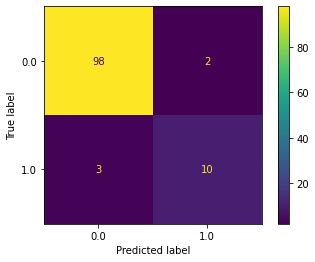

In [170]:
y_pred_dt = grid_dt.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.show()

In [174]:
# Otimizando hiperparâmetros para KNN

lista_etapas = [('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())]

pipe = Pipeline(lista_etapas)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(f1_score)

param_grid_knn= {"knn__weights" : ['uniform', 'distance'],
           "knn__algorithm" : ['ball_tree', 'brute', 'kd_tree'],
           "knn__metric" : ['manhattan', 'euclidean'],
           "knn__n_neighbors" : range(2, 5)}

grid_knn = GridSearchCV(estimator=pipe,
                       param_grid=param_grid_knn,
                       scoring=metrica,
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 6/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 7/10; 1/36] START knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/36] END knn__algorithm=ball_tree, knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 

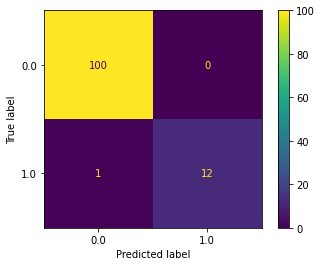

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       100
         1.0       1.00      0.92      0.96        13

    accuracy                           0.99       113
   macro avg       1.00      0.96      0.98       113
weighted avg       0.99      0.99      0.99       113



In [175]:
grid_knn.fit(X_train, y_train)
y_pred = grid_knn.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(classification_report(y_test, y_pred))